In [1]:
import requests
import json
from pprint import pprint

import pandas as pd
import matplotlib


In [2]:
def parse_to_date_uni(row):
    """Function to parse second timestamps to date-time format"""
    return pd.Timestamp(int(row['createdAtTimestamp']), unit='s')

def parse_to_date_curve(row):
    """Function to parse second timestamps to date-time format"""
    return pd.Timestamp(int(row['addedAt']), unit='s')

def parse_to_date_balancer(row):
    """Function to parse second timestamps to date-time format"""
    return pd.Timestamp(int(row['createTime']), unit='s')


## Uniswap

In [3]:
queryurl = "https://api.thegraph.com/subgraphs/name/uniswap/uniswap-v2"
series = "pairs"

BATCH_SIZE = 1000

last_ts = 0
data_uniswap = []

while True:
    query_uniswap = """
    query {""" + f"""
    pairs(first: {BATCH_SIZE}, orderBy: createdAtTimestamp, orderDirection: asc, where: {{ createdAtTimestamp_gt: {last_ts}}})""" + """{
        id
        createdAtTimestamp
    }""" + "}"

    r = requests.post(queryurl, json={'query': query_uniswap})
    res = json.loads(r.text)
    #reserves_json = json.loads(r.text)['data'][series]

    if "data" in set(res) and res["data"][series]:
        rows = res["data"][series]
        data_uniswap.extend(rows)
        last_ts = rows[-1]["createdAtTimestamp"]
        print(pd.Timestamp(int(last_ts), unit='s'))
    else:
        break

2020-06-14 01:16:13
2020-07-06 13:12:23
2020-07-28 11:57:11
2020-08-07 12:16:23
2020-08-18 00:07:14
2020-08-25 09:41:13
2020-09-02 08:08:14
2020-09-07 19:53:26
2020-09-14 18:05:58
2020-09-21 06:28:51
2020-09-25 21:23:08
2020-09-30 05:23:56
2020-10-04 14:35:30
2020-10-09 13:00:13
2020-10-14 01:40:04
2020-10-18 06:09:59
2020-10-22 01:16:23
2020-10-25 04:14:19
2020-10-28 23:50:54
2020-11-01 17:18:41
2020-11-06 01:03:54
2020-11-11 17:36:36
2020-11-17 17:35:59
2020-11-25 21:55:34
2020-12-05 15:58:40
2020-12-14 18:38:21
2020-12-24 19:24:23
2021-01-09 08:49:56
2021-01-25 11:50:43
2021-02-15 00:28:22
2021-03-08 15:44:02


In [4]:
df_uniswap = pd.DataFrame(data_uniswap) #convert to dataframe for plotting later

df_uniswap["date"]= df_uniswap.apply(parse_to_date_uni, axis=1) #parse time in seconds to date-time

df_uniswap_grouped = df_uniswap.groupby(df_uniswap['date'].dt.date).size().reset_index(name='Count') #count per day
df_uniswap_grouped['Cumsum'] = df_uniswap_grouped['Count'].cumsum() #cumulative sum over Count column
df_uniswap_grouped

,date,Count,Cumsum
0,2020-05-05,2,2
1,2020-05-06,1,3
2,2020-05-11,1,4
3,2020-05-13,2,6
4,2020-05-14,3,9
...,...,...,...
295,2021-03-04,32,30580
296,2021-03-05,35,30615
297,2021-03-06,31,30646
298,2021-03-07,29,30675


<AxesSubplot:xlabel='date'>

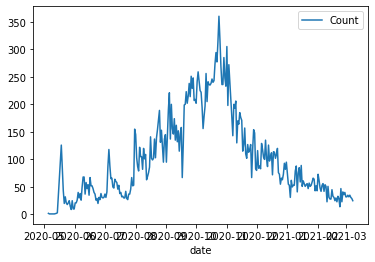

In [5]:
df_uniswap_grouped.plot(x='date', y='Count') #plot number of pools created per day

## Curve

In [6]:
query_curve = """
query {
 pools(orderBy: addedAt) {
    id
    addedAt
  }
}
"""


In [7]:
url = 'https://api.thegraph.com/subgraphs/name/protofire/curve'
r = requests.post(url, json={'query': query_curve})
curve_pools_json = json.loads(r.text)['data']['pools']

df_curve = pd.json_normalize(curve_pools_json)
# Only tracks 18 pools, according to https://github.com/protofire/curve-subgraph

In [8]:
df_curve["date"]= df_curve.apply(parse_to_date_curve, axis=1) #parse time in seconds to date-time

df_curve_grouped = df_curve.groupby(df_curve['date'].dt.date).size().reset_index(name='Count') #count per day
df_curve_grouped['Cumsum'] = df_curve_grouped['Count'].cumsum() #cumulative sum over Count column
df_curve_grouped

,date,Count,Cumsum
0,2020-06-20,8,8
1,2020-08-25,1,9
2,2020-09-06,1,10
3,2020-10-07,4,14
4,2020-10-08,1,15
5,2020-10-12,1,16
6,2020-10-20,1,17


<AxesSubplot:xlabel='date'>

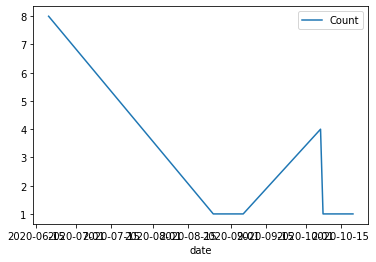

In [10]:
df_curve_grouped.plot(x='date', y='Count') #plot number of pools created per day

## Balancer

In [11]:
queryurl = "https://api.thegraph.com/subgraphs/name/balancer-labs/balancer"
series = "pools"

BATCH_SIZE = 100

last_ts = 0
data_balancer = []

while True:
    query_balancer = """
    query {""" + f"""
    pools(first: {BATCH_SIZE}, orderBy: createTime, orderDirection: asc, where: {{ createTime_gt: {last_ts}}})""" + """{
        id
        createTime
    }""" + "}"

    r = requests.post(queryurl, json={'query': query_balancer})
    res = json.loads(r.text)
    #reserves_json = json.loads(r.text)['data'][series]

    if "data" in set(res) and res["data"][series]:
        rows = res["data"][series]
        data_balancer.extend(rows)
        last_ts = rows[-1]["createTime"]
        print(pd.Timestamp(int(last_ts), unit='s'))
    else:
        break

2020-05-31 20:31:59
2020-06-09 00:57:13
2020-06-17 01:17:33
2020-06-23 17:32:36
2020-06-24 20:06:48
2020-06-26 16:22:44
2020-07-01 15:15:07
2020-07-06 05:58:33
2020-07-14 20:57:17
2020-07-24 00:04:23
2020-08-01 07:25:02
2020-08-05 20:16:40
2020-08-13 18:23:36
2020-08-21 16:34:44
2020-08-29 18:16:54
2020-09-07 05:55:31
2020-09-13 00:38:27
2020-09-21 05:43:47
2020-09-28 20:33:27
2020-10-08 10:32:12
2020-10-17 06:37:13
2020-10-28 13:32:38
2020-11-11 19:15:53
2020-11-23 09:05:06
2020-12-03 05:00:28
2020-12-18 01:33:44
2020-12-31 02:50:21
2021-01-23 17:35:12
2021-02-25 15:39:29
2021-03-07 20:32:12


In [12]:
df_balancer = pd.DataFrame(data_balancer)

df_balancer["date"]= df_balancer.apply(parse_to_date_balancer, axis=1) #parse time seconds to date-time

df_balancer_grouped = df_balancer.groupby(df_balancer['date'].dt.date).size().reset_index(name='Count') #count per day
df_balancer_grouped['Cumsum'] = df_balancer_grouped['Count'].cumsum()  #cumulative sum over Count column
df_balancer_grouped

,date,Count,Cumsum
0,2020-02-28,3,3
1,2020-03-13,6,9
2,2020-03-17,1,10
3,2020-03-26,3,13
4,2020-04-01,1,14
...,...,...,...
309,2021-03-03,2,2928
310,2021-03-04,10,2938
311,2021-03-05,3,2941
312,2021-03-06,1,2942


<AxesSubplot:xlabel='date'>

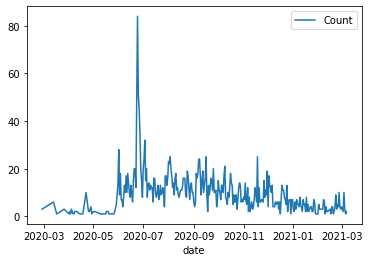

In [15]:
df_balancer_grouped.plot(x='date', y='Count')